# Similar to previous notebook, we use data augmentation. This notebook run on GPUs in a docker container.

## CNN 10 layer architecture.

In [1]:
reset -fs

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import pickle
import h5py
import gzip
import dl_functions
from IPython.display import display
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from tensorflow.python.lib.io import file_io
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
with file_io.FileIO("gs://wellio-kadaif-tasty-images-project-pre-processed-images/pre_processed_images/image_data_20000_50.txt", 'r') as f:
    X, y = pickle.load(f)

In [4]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.4,
                             zoom_range=0.1,
                             horizontal_flip=False,
                             fill_mode='nearest')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
X_train_fit, X_val, y_train_fit, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [7]:
y_train_fit_sparse = np_utils.to_categorical(y_train_fit, 2)

In [8]:
y_val_sparse = np_utils.to_categorical(y_val, 2)

In [9]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

In [10]:
datagen.fit(X_train)

In [11]:
IMG_SIZE = 50

In [12]:
model_1 = dl_functions.cnn_model_v_1(IMG_SIZE)

In [13]:
model_1.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [14]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
__________

>Increased `batch_size` from `128` to `1024` to increase GPU memory usage (otherwise, it 'wastes' time doing I/O to get batches of data).

In [15]:
model_1.fit_generator(datagen.flow(X_train_fit, y_train_fit_sparse, batch_size=128), steps_per_epoch=len(X_train_fit),
                                   epochs=25, validation_data=(X_val, y_val_sparse))

Epoch 1/25
12600/12600 [==============================] - 1161s - loss: 0.3229 - acc: 0.8637 - val_loss: 0.3278 - val_acc: 0.8707
Epoch 2/25
12600/12600 [==============================] - 1148s - loss: 0.2468 - acc: 0.9022 - val_loss: 0.2823 - val_acc: 0.8900
Epoch 3/25
12600/12600 [==============================] - 1147s - loss: 0.2442 - acc: 0.9055 - val_loss: 0.4469 - val_acc: 0.8214
Epoch 4/25
12600/12600 [==============================] - 1149s - loss: 0.2617 - acc: 0.9005 - val_loss: 0.3452 - val_acc: 0.8686
Epoch 5/25
12600/12600 [==============================] - 1160s - loss: 0.2917 - acc: 0.8893 - val_loss: 0.5673 - val_acc: 0.8364
Epoch 6/25
12600/12600 [==============================] - 1147s - loss: 0.3161 - acc: 0.8797 - val_loss: 0.3140 - val_acc: 0.8879
Epoch 7/25
12600/12600 [==============================] - 1147s - loss: 0.3430 - acc: 0.8696 - val_loss: 0.3266 - val_acc: 0.8800
Epoch 8/25
12600/12600 [==============================] - 1147s - loss: 0.3514 - acc: 0.86

In [16]:
score = model_1.evaluate(X_test, y_test_sparse, verbose=1)

5888/6000 [============================>.] - ETA: 0s

In [17]:
print('Test loss: {:0,.4f}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Test loss: 0.4675
Test accuracy: 85.17%


In [18]:
predicted_images = []
for i in model_1.predict(X_test):
    predicted_images.append(np.where(np.max(i) == i)[0])

In [19]:
print("AUC: {:.2%}\n".format(roc_auc_score(y_test, predicted_images)))

AUC: 85.21%



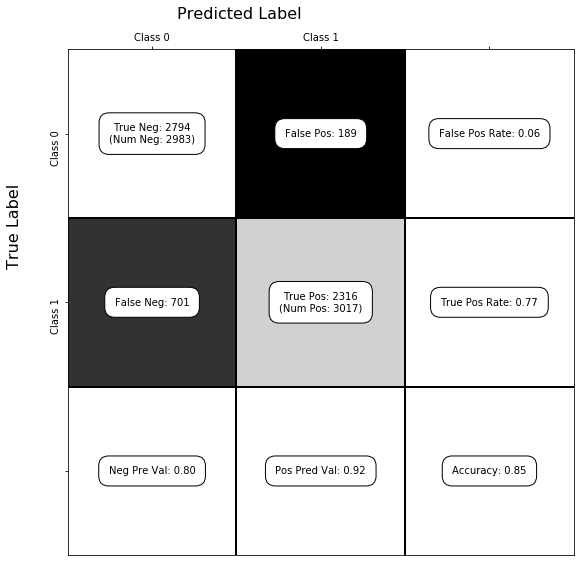

In [20]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images), ['Class 0', 'Class 1'])

In [21]:
predictions_probability = model_1.predict_proba(X_test)

5696/6000 [===========================>..] - ETA: 0s

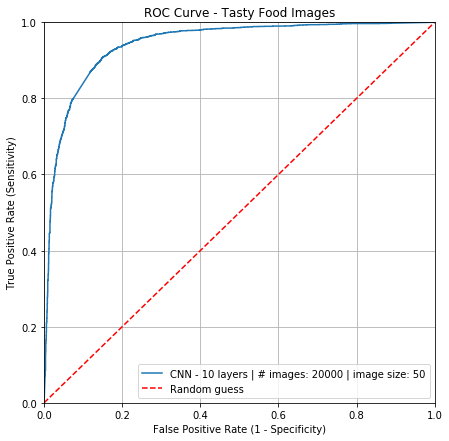

In [22]:
plt.figure(figsize=(7, 7))
dl_functions.plot_roc(y_test, predictions_probability[:,1], "CNN - " + str(len(model_1.layers)) + " layers | # images: " + str(len(X)) + " | image size: " + str(IMG_SIZE), "Tasty Food Images")

In [23]:
model_1.save('models/model_v1_20000_50_augmentation_gpu.h5')

In [24]:
model_1.save_weights('models/model_v1_20000_50_augmentation_weights_gpu.h5')